[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



===== SIGNAL DISTRIBUTION =====
        TSLA  NVDA  AAPL  MSFT
signal                        
HIGH       1     2   0.0   0.0
LOW       36    29  31.0  36.0
MEDIUM     4     3   3.0   0.0


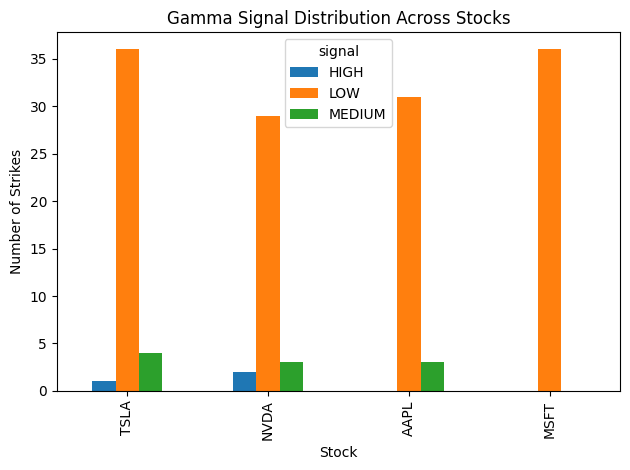

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# FUNCTION: GET SIGNAL DATA
# =========================
def get_gamma_signals(stock_symbol):
    ticker = yf.Ticker(stock_symbol)

    price_data = yf.download(stock_symbol, period="1mo")
    if isinstance(price_data.columns, pd.MultiIndex):
        price_data.columns = price_data.columns.get_level_values(0)

    current_price = price_data['Close'].iloc[-1]

    expiry = ticker.options[0]
    option_chain = ticker.option_chain(expiry)
    calls = option_chain.calls
    calls['volume'] = calls['volume'].fillna(0)

    atm_calls = calls[
        (calls['strike'] >= current_price - 50) &
        (calls['strike'] <= current_price + 50)
    ].copy()

    atm_calls['gamma_score'] = atm_calls['volume'] * (atm_calls['openInterest'] + 1)

    def classify(score):
        if score > 50000:
            return "HIGH"
        elif score > 20000:
            return "MEDIUM"
        else:
            return "LOW"

    atm_calls['signal'] = atm_calls['gamma_score'].apply(classify)

    return atm_calls[['signal']]

# =========================
# ANALYSIS
# =========================
stocks = ["TSLA", "NVDA", "AAPL", "MSFT"]

signal_summary = {}

for stock in stocks:
    signals = get_gamma_signals(stock)
    signal_summary[stock] = signals['signal'].value_counts()

summary_df = pd.DataFrame(signal_summary).fillna(0)

print("\n===== SIGNAL DISTRIBUTION =====")
print(summary_df)

# =========================
# VISUALIZATION
# =========================
summary_df.T.plot(kind='bar')
plt.xlabel("Stock")
plt.ylabel("Number of Strikes")
plt.title("Gamma Signal Distribution Across Stocks")
plt.tight_layout()
plt.show()
